In [48]:
import pandas as pd

import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from collections import Counter
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from sklearn.feature_extraction.text import TfidfVectorizer

In [49]:
df = pd.read_csv('Auronplay_videos.csv')
df['transcript'] = df['transcript'].replace('Subtitle not available', ' ')
df['transcript'] = df['transcript'].str.replace('\xa0__\xa0', 'insulta')

In [76]:
type(df['transcript'][1])

str

In [58]:
occurrences_per_transcript = df['transcript'].str.count(r'\[insulta\]')

# Calculate total occurrences
total_insults = occurrences_per_transcript.sum()

# Calculate average occurrence per transcript
average_occurrence = total_insults / len(df)

print(f"Average occurrences of '[insulta]' per transcript: {average_occurrence:.2f}")
print(f"Total occurrences of '[insulta]' per transcript: {total_insults:.2f}")

Average occurrences of '[insulta]' per transcript: 35.70
Total occurrences of '[insulta]' per transcript: 12529.00


In [52]:
# Preprocess the transcripts
def preprocess(text):
    spanish_stopwords = set(stopwords.words('spanish'))
    tokens = nltk.word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in spanish_stopwords]  # Remove non-alphabetic tokens and stopwords
    return tokens

processed_transcripts = [preprocess(transcript) for transcript in df['transcript']]



In [78]:
type(processed_transcripts[1])

list

In [53]:
# 1. Identify commonly used phrases using N-grams
all_ngrams = [ngram for transcript in processed_transcripts for ngram in ngrams(transcript, 3)]  # trigrams
common_phrases = Counter(all_ngrams).most_common(20)
print("Common Phrases:")
for phrase, freq in common_phrases:
    print(f"{' '.join(phrase)}: {freq}")



Common Phrases:
ay ay ay: 710
vale vale vale: 614
bueno bueno bueno: 566
mira mira mira: 533
vamos vamos vamos: 295
aquí aquí aquí: 277
bien bien bien: 229
cago insulta madre: 186
hola hola hola: 178
dale dale dale: 154
voy voy voy: 127
ver ver ver: 126
corre corre corre: 109
música música música: 105
ven ven ven: 90
insulta insulta insulta: 85
uy uy uy: 77
cuidado cuidado cuidado: 77
hola buenas tardes: 73
así así así: 73


In [54]:
# 2. Identify topics using LDA
dictionary = Dictionary(processed_transcripts)
corpus = [dictionary.doc2bow(transcript) for transcript in processed_transcripts]
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=5, passes=15, workers=4)
print("\nTopics:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx}, Words: {topic}")




Topics:
Topic: 0, Words: 0.008*"aquí" + 0.007*"árbol" + 0.005*"vale" + 0.005*"insulta" + 0.005*"bien" + 0.005*"música" + 0.004*"acá" + 0.004*"casa" + 0.004*"bueno" + 0.004*"si"
Topic: 1, Words: 0.021*"aquí" + 0.016*"si" + 0.014*"vale" + 0.013*"insulta" + 0.013*"ver" + 0.011*"bueno" + 0.010*"voy" + 0.010*"ahora" + 0.010*"mira" + 0.009*"vamos"
Topic: 2, Words: 0.022*"insulta" + 0.014*"música" + 0.013*"si" + 0.012*"vale" + 0.011*"aquí" + 0.010*"bien" + 0.009*"ahora" + 0.009*"voy" + 0.009*"ver" + 0.009*"vamos"
Topic: 3, Words: 0.021*"insulta" + 0.017*"aquí" + 0.015*"vale" + 0.011*"si" + 0.011*"ver" + 0.010*"voy" + 0.010*"bueno" + 0.010*"mira" + 0.010*"eh" + 0.009*"música"
Topic: 4, Words: 0.015*"si" + 0.011*"insulta" + 0.008*"ver" + 0.007*"ahora" + 0.007*"aquí" + 0.007*"voy" + 0.007*"vale" + 0.006*"hacer" + 0.006*"creo" + 0.006*"bueno"


In [55]:
# 3. Identify unique terms/values using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.85)
tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(transcript) for transcript in processed_transcripts])
feature_names = tfidf_vectorizer.get_feature_names_out()
sorted_items = sorted(list(enumerate(tfidf_matrix.sum(axis=0).tolist()[0])), key=lambda x: x[1], reverse=True)
print("\nUnique Terms:")
for idx, score in sorted_items[:10]:
    print(f"{feature_names[idx]}: {score}")



Unique Terms:
eh: 27.517089263836805
casa: 14.652203264987033
ay: 12.562360672742972
coche: 11.20501385103986
juan: 11.116622451196948
pato: 10.67774744184818
cuidado: 10.633631649257165
visto: 9.776084894921649
focus: 9.58672672465003
cosas: 9.509725826402304


In [66]:
all_tokens = [token for transcript in processed_transcripts for token in transcript]

# Count the occurrences of each token
word_freq = Counter(all_tokens)

# Display the 10 most common words and their frequencies
most_common_words = word_freq.most_common(10)
print(most_common_words)

# If you prefer the output in a DataFrame
df_word_freq = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
print(df_word_freq)

[('insulta', 12544), ('aquí', 10526), ('si', 9332), ('vale', 8907), ('ver', 7230), ('voy', 6580), ('bueno', 6522), ('música', 6107), ('ahora', 6092), ('vamos', 5646)]
      Word  Frequency
0  insulta      12544
1     aquí      10526
2       si       9332
3     vale       8907
4      ver       7230
5      voy       6580
6    bueno       6522
7   música       6107
8    ahora       6092
9    vamos       5646


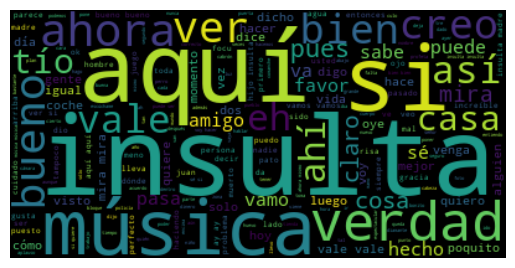

In [79]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Convert the list of tokens back into a single string for each transcript
all_text = ' '.join([' '.join(transcript) for transcript in processed_transcripts])

# Generate a word cloud image
wordcloud = WordCloud(background_color='white', width=800, height=400, max_font_size=90, contour_width=3, contour_color='steelblue').generate(all_text)

# Display the generated image with matplotlib
wordcloud = WordCloud().generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("transcript_preprocessed.png")
plt.show()